# Sentiment Analysis Model

This notebook presents the development and evaluation of a sentiment analysis model using various machine learning techniques. The goal is to classify text data into one of four sentiment categories: Positive, Negative, Neutral, and Irrelevant. 

## Key Components:
1. **Data Preparation**: 
   - The dataset is preprocessed by removing unnecessary columns and replacing sentiment values for better understanding.
   - The text data is cleaned and vectorized using TF-IDF vectorization.
2. **Visualization**:
   - The distribution of sentiment data is visualized using bar charts.
   - Word clouds and heatmaps are used to display the frequency of words in the positive, negative, neutral, and irrelevant sentiment texts.

3. **Model Training**:
   - Three different machine learning models are trained for sentiment classification: Logistic Regression, Bernoulli Naive Bayes, and Support Vector Classification (SVC).

4. **Model Evaluation**:
   - The models are evaluated using classification reports, confusion matrices, and visualizations to determine their performance.

5. **User Interaction**:
   - A Streamlit application is developed to allow users to input text and select a model to predict sentiment.
   - The application displays predictions from the selected model.

This comprehensive approach ensures a robust sentiment analysis system capable of providing insights into text data across different sentiment categories.


In [5]:
# Utilities Required for sentiment analysis model trainng
import re
import pickle
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# Load train and test data from Google Drive with specified encoding
dataset = pd.read_csv('/content/drive/MyDrive/sentiment_dataset/twitter_training.csv', encoding='ISO-8859-1')
# Inspect the first few rows to see the actual column names
print(dataset.head())
print("Columns before renaming:", dataset.columns)

   2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...     
Columns before renaming: Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')


In [8]:

# Rename columns
dataset.rename(columns={'Positive': 'sentiment', 'im getting on borderlands and i will murder you all ,': 'text'}, inplace=True)

# Removing the unnecessary columns.
dataset = dataset[['sentiment', 'text']]

# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4, 1)


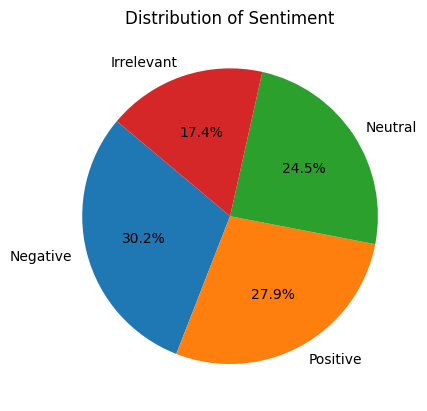

In [9]:

# Plotting the distribution for the dataset using a pie chart
dataset['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, title='Distribution of Sentiment')
plt.ylabel('')
plt.show()


In [10]:
import nltk
from nltk.corpus import stopwords
# Download stopwords and wordnet
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [11]:

# Function to preprocess text
def preprocess_text(text, emoji_dict, lemmatizer, stop_words):
    # Lower casing
    text = text.lower()

    # Replacing URLs
    text = re.sub(r'http\S+|www\S+|https\S+', 'URL', text, flags=re.MULTILINE)

    # Replacing Emojis
    for emoji in emoji_dict.keys():
        text = text.replace(emoji, "EMOJI" + emoji_dict[emoji])

    # Replacing Usernames
    text = re.sub(r'@\w+', 'USER', text)

    # Removing Non-Alphabets
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)

    # Removing Consecutive letters
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Removing Short Words
    text = ' '.join([word for word in text.split() if len(word) > 1])

    # Removing Stopwords and Lemmatizing
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

    return text

# Define an emoji dictionary
emoji_dict ={':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Apply preprocessing
dataset['text'] = dataset['text'].apply(lambda x: preprocess_text(str(x), emoji_dict, lemmatizer, stop_words))


# Verify the preprocessing by inspecting the first few rows
print(dataset.head())


  sentiment                          text
0  Positive            coming border kill
1  Positive    im getting borderland kill
2  Positive   im coming borderland murder
3  Positive  im getting borderland murder
4  Positive  im getting borderland murder


In [13]:
# Print unique values in the sentiment column
print(dataset['sentiment'].unique())


['Positive' 'Neutral' 'Negative' 'Irrelevant']


Number of Irrelevant sentiment texts: 12990
Number of Negative sentiment texts: 22542
Number of Neutral sentiment texts: 18318
Number of Positive sentiment texts: 20831


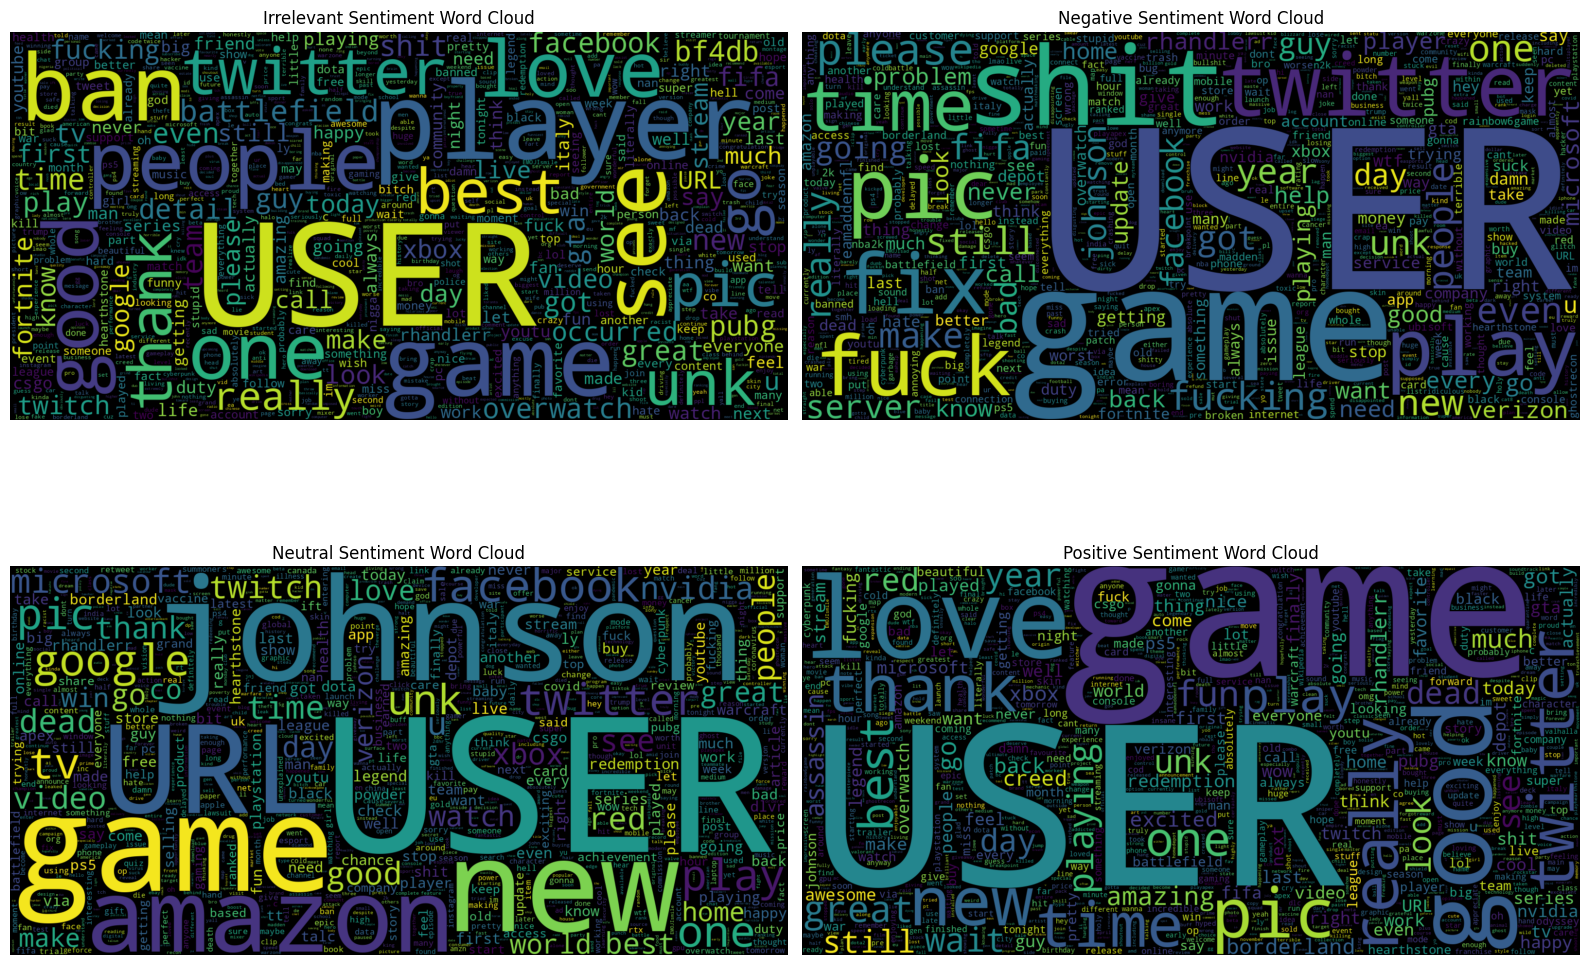

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to generate and display word cloud for a given sentiment
def generate_wordcloud(sentiment_label, dataset):
    data = dataset[dataset['sentiment'] == sentiment_label]['text'].tolist()

    # Check if data is empty
    if not data:
        print(f"No {sentiment_label} sentiment data found.")
    else:
        print(f"Number of {sentiment_label} sentiment texts: {len(data)}")

        # Generate and display the word cloud
        wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(data))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')  # Hide the axes
        plt.title(f'{sentiment_label} Sentiment Word Cloud')

# Replacing values for better understanding (assuming 'dataset' is already defined and loaded)
dataset['sentiment'] = dataset['sentiment'].replace({0: 'Irrelevant', 1: 'Positive', 2: 'Neutral', 3: 'Negative'})

# Create a 2x2 grid for plotting
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
generate_wordcloud('Irrelevant', dataset)

plt.subplot(2, 2, 2)
generate_wordcloud('Negative', dataset)

plt.subplot(2, 2, 3)
generate_wordcloud('Neutral', dataset)

plt.subplot(2, 2, 4)
generate_wordcloud('Positive', dataset)

plt.tight_layout()
plt.show()


Number of Irrelevant sentiment texts: 12990
Number of Negative sentiment texts: 22542
Number of Neutral sentiment texts: 18318
Number of Positive sentiment texts: 20831


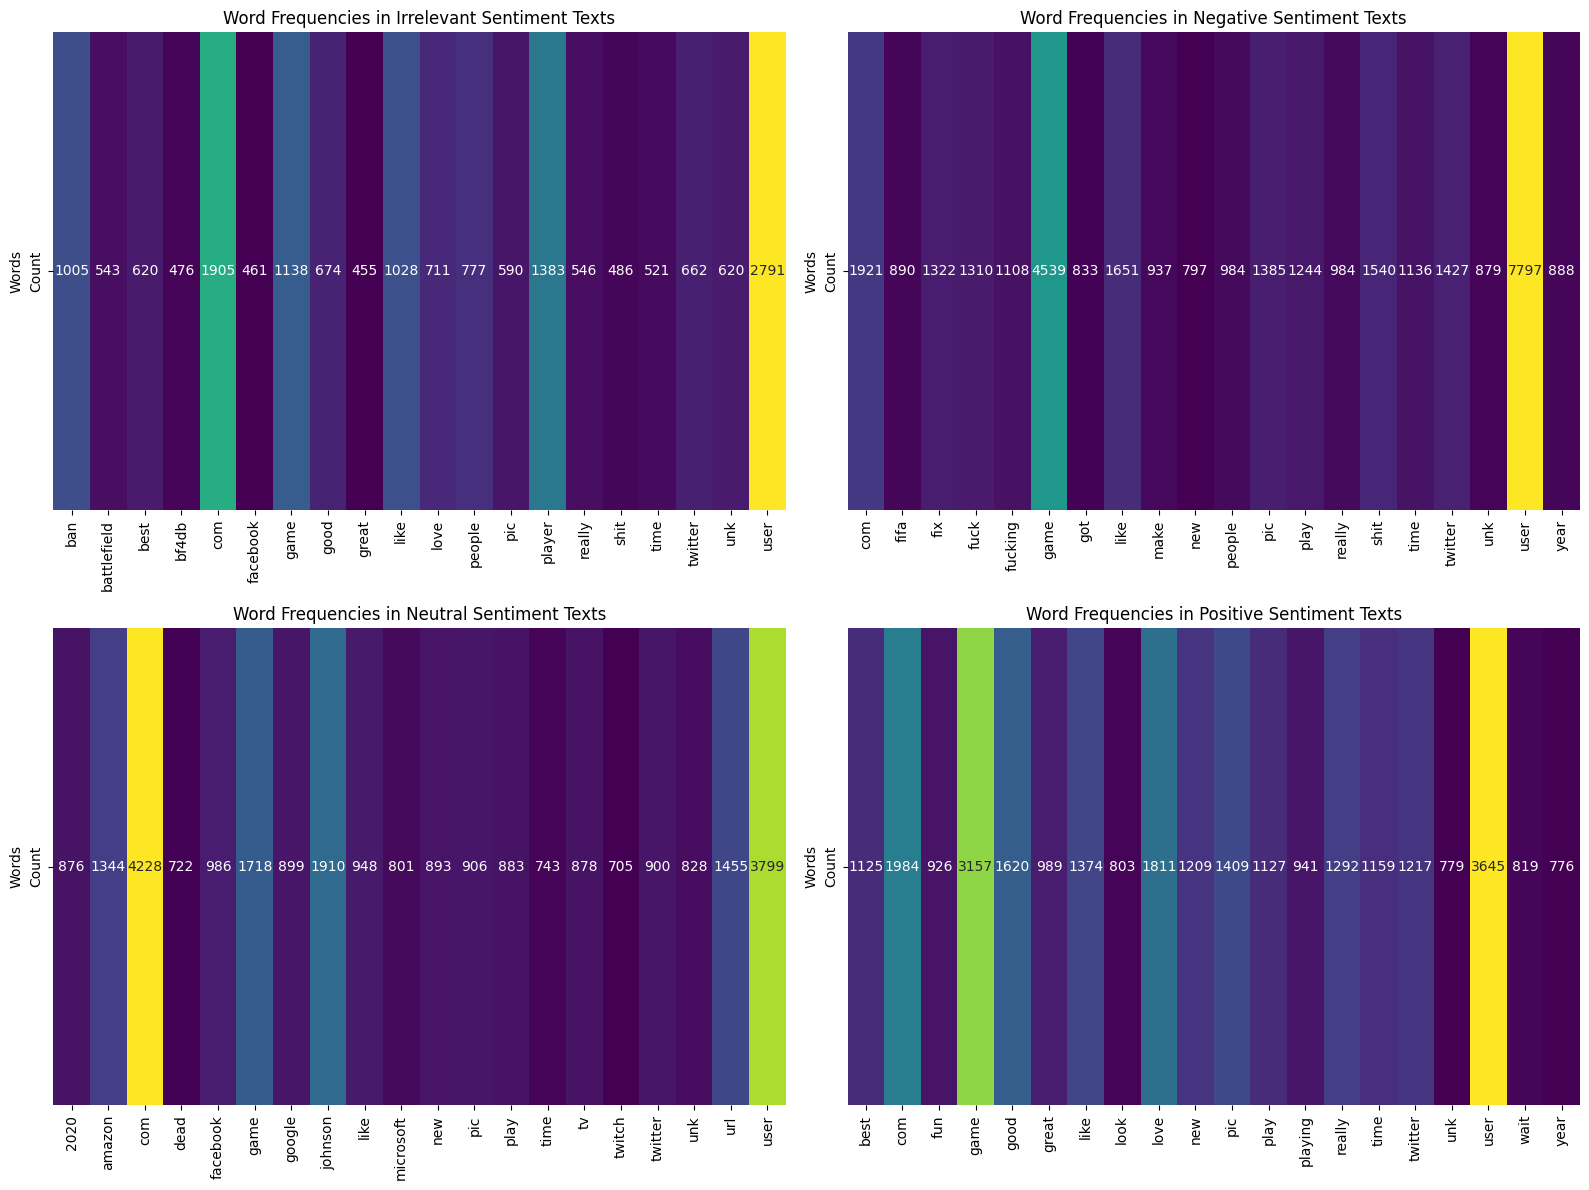

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to plot word frequencies for a given sentiment
def plot_word_frequencies(sentiment_label, dataset):
    data = dataset[dataset['sentiment'] == sentiment_label]['text'].tolist()

    # Check if data is empty
    if not data:
        print(f"No {sentiment_label} sentiment data found.")
    else:
        print(f"Number of {sentiment_label} sentiment texts: {len(data)}")

        # Create a CountVectorizer to count word frequencies
        vectorizer = CountVectorizer(max_features=20, stop_words='english')
        word_counts = vectorizer.fit_transform(data)

        # Get word frequencies
        word_freq = word_counts.toarray().sum(axis=0)
        words = vectorizer.get_feature_names_out()

        # Create a DataFrame for the heatmap
        word_freq_df = pd.DataFrame(word_freq, index=words, columns=['Count'])

        # Plot the heatmap
        sns.heatmap(word_freq_df.T, annot=True, fmt="d", cmap='viridis', cbar=False)
        plt.title(f'Word Frequencies in {sentiment_label} Sentiment Texts')
        plt.ylabel('Words')

# Replacing values for better understanding (assuming 'dataset' is already defined and loaded)
dataset['sentiment'] = dataset['sentiment'].replace({0: 'Irrelevant', 1: 'Positive', 2: 'Neutral', 3: 'Negative'})

# Create a 2x2 grid for plotting
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plot_word_frequencies('Irrelevant', dataset)

plt.subplot(2, 2, 2)
plot_word_frequencies('Negative', dataset)

plt.subplot(2, 2, 3)
plot_word_frequencies('Neutral', dataset)

plt.subplot(2, 2, 4)
plot_word_frequencies('Positive', dataset)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming dataset['text'] contains the text data and dataset['sentiment'] contains the labels
X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset['sentiment'],
                                                    test_size=0.20, random_state=0)

print(f'Data Split done.')


Data Split done.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer with n-grams and maximum features
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)

# Fit the vectorizer on the training data
vectoriser.fit(X_train)

# Print confirmation and the number of feature words
print(f'Vectoriser fitted.')
print('No. of feature words: ', len(vectoriser.get_feature_names_out()))
# Save the vectorizer
with open('vectoriser.pickle', 'wb') as file:
    pickle.dump(vectoriser, file)


Vectoriser fitted.
No. of feature words:  258083


In [ ]:
# Transform the training and test data using the fitted vectorizer
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

print(f'Data Transformed.')


Data Transformed.


              precision    recall  f1-score   support

    Negative       1.00      0.17      0.29      2569
     Neutral       0.69      0.92      0.79      4502
    Positive       0.97      0.52      0.67      3658
  Irrelevant       0.60      0.94      0.74      4208

    accuracy                           0.70     14937
   macro avg       0.82      0.64      0.62     14937
weighted avg       0.79      0.70      0.66     14937



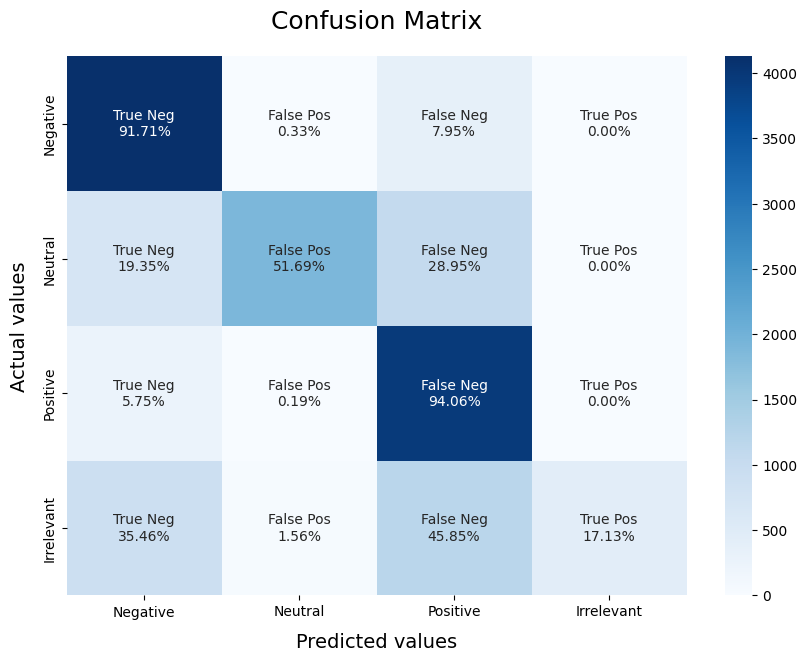

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def model_Evaluate(model):
    # Predict values for the Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive', 'Irrelevant']))

    # Compute and plot the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred, labels=['Negative', 'Neutral', 'Positive', 'Irrelevant'])

    categories = ['Negative', 'Neutral', 'Positive', 'Irrelevant']

    # Compute confusion matrix and percentages
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

    # Flatten the confusion matrix and compute percentages
    cf_matrix_flat = cf_matrix.flatten()
    cf_matrix_sum = np.sum(cf_matrix, axis=1)  # sum of each row
    group_percentages = [f'{(cf_matrix_flat[i] / cf_matrix_sum[i // len(categories)]):.2%}' for i in range(len(cf_matrix_flat))]

    # Generate labels for the heatmap
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names * len(categories), group_percentages)]
    labels = np.asarray(labels).reshape(len(categories), len(categories))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='', xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
    plt.show()

# Evaluate the Bernoulli Naive Bayes model
model_Evaluate(BNBmodel)


              precision    recall  f1-score   support

    Negative       0.96      0.88      0.92      2569
     Neutral       0.94      0.93      0.94      4502
    Positive       0.92      0.92      0.92      3658
  Irrelevant       0.89      0.94      0.91      4208

    accuracy                           0.92     14937
   macro avg       0.93      0.92      0.92     14937
weighted avg       0.93      0.92      0.92     14937



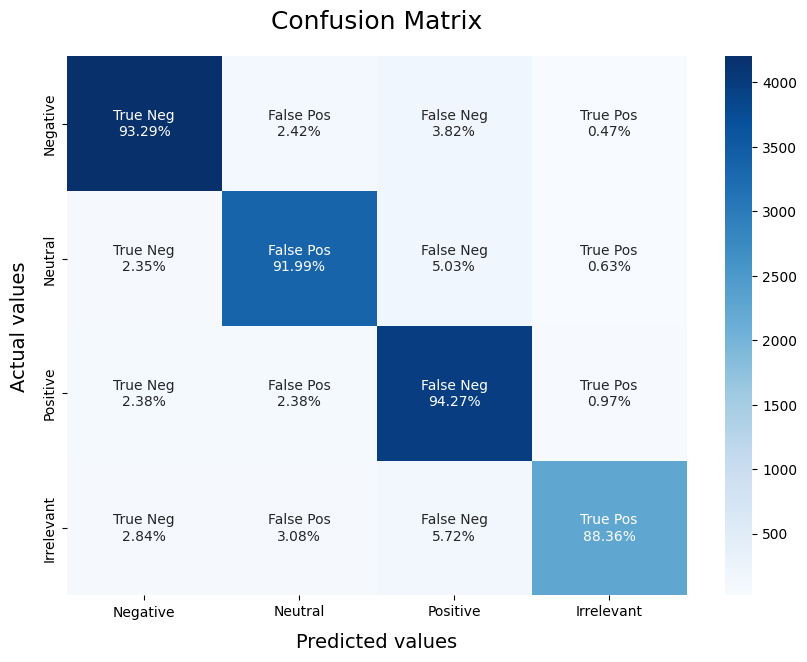

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

    Negative       0.94      0.82      0.88      2569
     Neutral       0.86      0.93      0.89      4502
    Positive       0.89      0.88      0.88      3658
  Irrelevant       0.90      0.90      0.90      4208

    accuracy                           0.89     14937
   macro avg       0.90      0.88      0.89     14937
weighted avg       0.89      0.89      0.89     14937



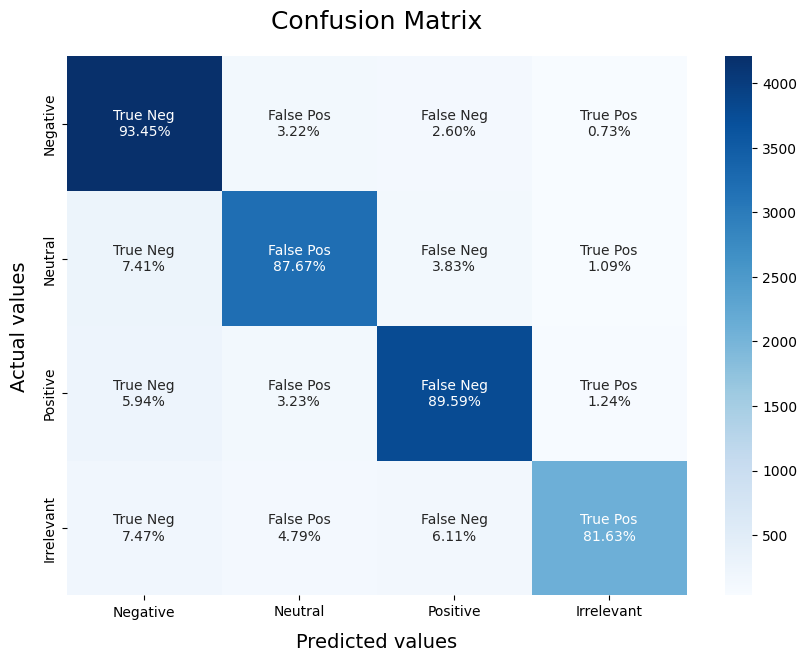

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [ ]:
# Save the trained model
with open('Sentiment_SVC.pickle', 'wb') as file:
    pickle.dump(SVCmodel, file)
file.close()

file = open('Sentiment_LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment_BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()